In [1]:
from astropy.table import Table, vstack, Column, hstack,unique
from astropy.io import fits
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import NullFormatter
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from grizli import utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import eazy.utils
from astropy.cosmology import Planck15
from astropy.visualization import LogStretch
from matplotlib.ticker import MaxNLocator
from scipy import stats

In [2]:
# Get vdw table 
vdw = utils.GTable.read('../galfit_measurements/master_galfit.fits')


# Compile photometric catalog for 3dhst
version = 'v4.1'

cats = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
cat = vstack(cats)

zouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.zout'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
zout = vstack(zouts)

fouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Fast/{0}_3dhst.{1}.fout'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
fout = vstack(fouts)

colors = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/RF_colors/{0}_3dhst.{1}.master.RF'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
color = vstack(colors)

cat_3dhst = hstack([cat,zout,fout,color])


# lengths
print(len(vdw), len(cat_3dhst))


#match catalogs
idx, dr = cat_3dhst.match_to_catalog_sky(vdw)
cat_3dhst = cat_3dhst[idx]

# This is vdw catalog with corresponding photometry, redshifts, masses
master_3dhst = hstack([vdw,cat_3dhst])

119181 207967


In [3]:
# Make cuts from vdw2014 paper
# Mass: M* > 10^9.2
# H(f160w) < 24.5
# Galfit f < 3
# Redshift: 0.7 < z < 1.5
master_3dhst['kpcperarc'] = Planck15.kpc_proper_per_arcmin(master_3dhst['z_peak']).to(u.kpc/u.arcsec)
master_3dhst['u-v'] = -2.5*np.log10(master_3dhst['L153']/master_3dhst['L155'])
master_3dhst['v-j'] = -2.5*np.log10(master_3dhst['L155']/master_3dhst['L161'])

clip = master_3dhst['use_phot'] == 1
clip = master_3dhst['lmass'] > 9
clip &= (25-2.5*np.log10(master_3dhst['f_F160W'])) < 24.5
clip &= master_3dhst['f'] < 3
clip &= (master_3dhst['z_peak'] > 0.1) & (master_3dhst['z_peak'] < 3)


sample_3dhst = master_3dhst[clip]

clip.sum()

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/numpy/lib/function_base.py:2831: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


23038

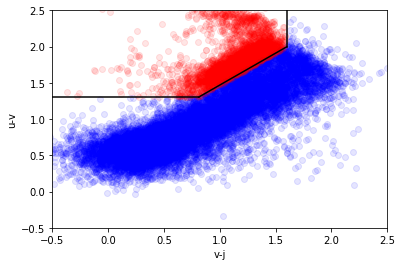

In [4]:
# Determine what is star forming and what is not. Plot it.
# values taken from Kate's paper (2011)

# True means sf, False means passive
sf = np.ones(len(sample_3dhst)).astype('bool')
sample_3dhst['sf'] = np.ones(len(sample_3dhst))
for i,row in enumerate(sample_3dhst):
    if (row['v-j']<=1.6) & (row['v-j']>0.81):
        lim = 0.88*row['v-j']+0.59
        if row['u-v'] > lim:
            sf[i] = False
            row['sf'] = 0
    elif (row['v-j'] <= 0.81):
        if row['u-v'] > 1.3:
            sf[i] = False
            row['sf'] = 0
            
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(sample_3dhst['v-j'][sf],sample_3dhst['u-v'][sf],alpha=0.1,c='b')
ax.scatter(sample_3dhst['v-j'][~sf],sample_3dhst['u-v'][~sf],alpha=0.1,c='r')
ax.set_ylim([-0.5,2.5])
ax.set_xlim([-0.5,2.5])
x1 = np.linspace(-0.5,0.81)
y1 = 1.3*np.ones(len(x1))
x2 = np.linspace(0.81,1.6)
y2 = 0.88*x2+0.59
y3 = np.linspace(2,2.5)
x3 = 1.6*np.ones(len(y3))
ax.plot(x1,y1,c='k')
ax.plot(x2,y2,c='k')
ax.plot(x3,y3,c='k')
ax.set_xlabel('v-j')
ax.set_ylabel('u-v')
plt.show()

861
4218
4981
5217
3020
1528


/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


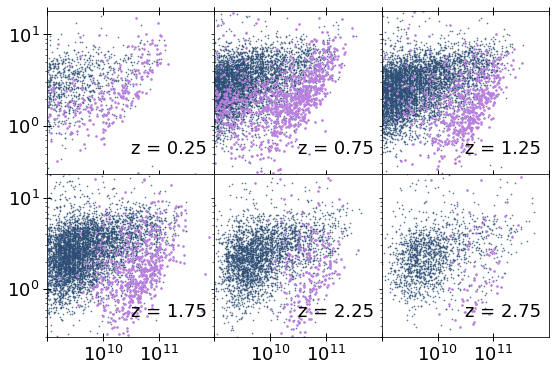

In [100]:
t = sample_3dhst
fig = plt.figure(figsize=[9,6])
import matplotlib.ticker
redshift = [0.25,0.75,1.25,1.75,2.25,2.75]

for i,z in enumerate(redshift):
    selz = (t['z_peak']>z-0.25)&(t['z_peak']<z+0.25)
    tab = t[selz]
    sf = tab['sf'].astype(bool)
    print(len(tab[sf]))
    
    fig.add_subplot(2, 3, i+1)
    plt.scatter(tab['lmass'][sf],tab['re'][sf]*tab['kpcperarc'][sf],s=0.5,alpha=0.7,c='#2D4E76')
    plt.scatter(tab['lmass'][~sf],tab['re'][~sf]*tab['kpcperarc'][~sf],s=2.5,color='#B97FDF')
    plt.semilogy()
    if i == 0:
        plt.text(10.5,0.5,'z = 0.25',size=18)
        plt.tick_params(axis='x', top = True, labelbottom=False,direction ='inout',length=8, width=1)
        plt.tick_params(axis='y', labelsize=18, direction ='inout',length=8, width=1)
    elif i == 1:
        plt.text(10.5,0.5,'z = 0.75',size=18)
        plt.tick_params(axis='x', top = True, labelbottom=False,direction ='inout',length=8, width=1)
        plt.tick_params(axis='y', labelleft=False)
    elif i == 2:
        plt.text(10.5,0.5,'z = 1.25',size=18)
        plt.tick_params(axis='x', labelbottom=False,direction ='inout',length=8, width=1)
        plt.tick_params(axis='x', top = True, labeltop=False, direction='inout',length=8, width=1)
        plt.tick_params(axis='y', labelleft=False)
    elif i == 3:
        plt.text(10.5,0.5,'z = 1.75',size=18)
        plt.tick_params(axis='y',labelsize=18, direction ='inout',length=8, width=1)
        plt.tick_params(axis='x',labelsize=18, direction ='inout',length=8, width=1)
        plt.xticks(np.arange(9, 12, step=1),('',r'$10^{10}$',r'$10^{11}$',''))
    elif i == 4:
        plt.text(10.5,0.5,'z = 2.25',size=18)
        plt.tick_params(axis='y', labelleft=False)
        plt.tick_params(axis='x',labelsize=18, direction ='inout',length=8, width=1)
        plt.xticks(np.arange(9, 12, step=1),('',r'$10^{10}$',r'$10^{11}$',''))
    elif i == 5:
        plt.text(10.5,0.5,'z = 2.75',size=18)
        plt.tick_params(axis='y', labelleft=False)
        plt.tick_params(axis='x',labelsize=18, direction ='inout',length=8, width=1)
        plt.xticks(np.arange(9, 12, step=1),('',r'$10^{10}$',r'$10^{11}$',''))
    
    plt.ylim([0.3,18])
    plt.xlim([9,12])

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig('mass_size.png',dpi=400,transparent=True)
    
# ax = fig.add_subplot(111)

# ax.scatter(sample_3dhst['lmass'][sf],sample_3dhst['re'][sf]*sample_3dhst['kpcperarc'][sf],c='gray',alpha=0.5,s=2)
# ax.scatter(sample_3dhst['lmass'][~sf],sample_3dhst['re'][~sf]*sample_3dhst['kpcperarc'][~sf],c='lightgray',s=2)

fig.show()

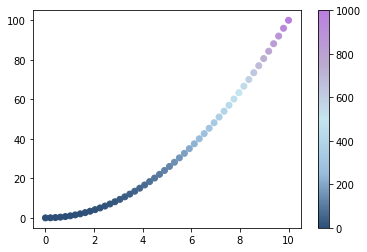

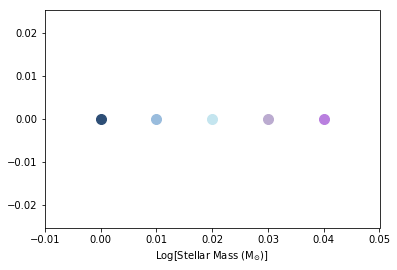

In [167]:
from matplotlib.colors import LinearSegmentedColormap
x = np.linspace(0,10)
y = x**2
c = x*y
cmap = LinearSegmentedColormap.from_list("", ["#2D4E76","#99BCDD","#C4E5EF","#BBABD0","#B97FDF"])
plt.scatter(x,y,c=c, cmap=cmap)
plt.colorbar()
plt.show()


plt.scatter(0,0,s=100,c="#2D4E76")
plt.scatter(0.01,0,s=100,c="#99BCDD")
plt.scatter(0.02,0,s=100,c="#C4E5EF")
plt.scatter(0.03,0,s=100,c="#BBABD0")
plt.scatter(0.04,0,s=100,c="#B97FDF")
plt.xlabel(r'Log[Stellar Mass (M$_{\odot}$)]')

plt.xlim([-0.01,0.05])

plt.savefig('/Users/alizabeverage/Downloads/mass.png',dpi=400,transparent=True)

#norm=plt.Normalize(0,10**2*10)


In [19]:
# Compile photometric catalog for 3dhst
version = 'v4.1'

cats = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Catalog/{0}_3dhst.{1}.cat'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
cat = vstack(cats)
cat['cat'] = '3dhst'

zouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Eazy/{0}_3dhst.{1}.zout'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
zout = vstack(zouts)

fouts = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/Fast/{0}_3dhst.{1}.fout'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
fout = vstack(fouts)

colors = [ utils.read_catalog('../tables/{0}_3dhst.{1}.cats/RF_colors/{0}_3dhst.{1}.master.RF'.format(field, version)) for field in ['uds','aegis','cosmos','goodss','goodsn']]
color = vstack(colors)

cat_3dhst = hstack([cat,zout,fout,color])
len(cat_3dhst)

207967

In [137]:
def empirical_mass_POSTER(cat, zout, fout, root='3dhst', mag_band='F140W', mag_ZP=23.9, phot_bands=['F125W', 'F160W'], degree=[5,5,5], clf=None, zshow=1., dq=None, static_fit=None):
    # Color
    blue = cat[phot_bands[0]]
    red = cat[phot_bands[1]]
    phot_color = -2.5*np.log10(np.maximum(np.maximum(blue, 1.e-6)/np.maximum(red, 1.e-6), 1e-6))

    # Magnitude
    hmag = mag_ZP - 2.5*np.log10(np.maximum(cat[mag_band], 1e-4))

    # Input data / output vector
    z = np.maximum(zout['z_peak'].data.data, 0)
    z[~np.isfinite(z)] = 0

    Xfull = np.vstack([np.log(1+z), hmag.data.data, phot_color.data.data]).T
    yobs = fout['lmass']
    # Transform data for polynomial model
    if static_fit is None:
        poly = PolynomialFeatures(np.max(degree))
    else:
        clf, poly, use_powers = static_fit

    X_ = poly.fit_transform(Xfull)

    # DQ selection: stars, etc.
    clip = (cat[mag_band] > 0) & (hmag < 28) & (phot_color < 10) & (phot_color > -10) & np.isfinite(fout['lmass']) & (blue > 0) & (red > 0) & (z > 0.02)

    if dq is not None:
        clip &= dq
    
    if ('star' in cat.colnames) & ('star_flag' in cat.colnames):
        clip &= (((cat['cat'] == 'uvista') & (cat['nan_contam'] == 0) & (cat['contamination'] == 0) & (cat['star'] == 0)) | ((cat['cat'] == '3dhst') & (cat['star_flag'] != 1) & (cat['use_phot'] == 1)))
    
    elif ('star' in cat.colnames) & ('star_flag' not in cat.colnames):
        clip &= (cat['cat'] == 'uvista') & (cat['nan_contam'] == 0) & (cat['contamination'] == 0) & (cat['star'] == 0)
    
    elif ('star' not in cat.colnames) & ('star_flag' in cat.colnames):
        clip &= (cat['cat'] == '3dhst') & (cat['star_flag'] != 1) & (cat['use_phot'] == 1)
        clip &= hmag < 24
        clip &= (z>0.6) & (z<1.6)
    
    #fix astropy masking BS
    clip = np.array(clip)
    
    
    ########################
    ### Limit polynomial degree by parameter
    powers = []
    for p in poly.get_feature_names():
        pdict = {}
        for k in p.split():
            if k.startswith('x'):
                i = int(k[1:].split('^')[0])
                if '^' in k:
                    power = int(k.split('^')[1])
                else:
                    power = 1

                pdict[i] = power

        p_i = []
        for i in range(poly.n_input_features_):
            if i in pdict:
                p_i.append(pdict[i])
            else:
                p_i.append(0)

        powers.append(p_i)
        #print(p, p_i)

    if static_fit is None:
        for i in range(poly.n_input_features_):
            if i == 0:
                use_powers = np.array(powers)[:,i] <= degree[i]
            else:
                use_powers &= np.array(powers)[:,i] <= degree[i]

    ######################
    ### Fit the Polynomial model        
    if static_fit is None:
        if clf is None:
            clf = linear_model.LinearRegression()

        clf.fit(X_[clip,:][:,use_powers], yobs[clip])

    y_pred = clf.predict(X_[:,use_powers])
    #######################
    ### Make a figure
    cmap = LinearSegmentedColormap.from_list("", ["#2D4E76","#99BCDD","#C4E5EF","#BBABD0","#B97FDF"])
    fig = plt.figure(figsize=[8,3])

    #zshow = 1.
    sel = clip & (np.abs(zout['z_peak'] - zshow) < 0.1)

    ax = fig.add_subplot(121)
    ax.text(0.95, 0.95, 'deg[z,mag,color]={0}'.format(degree), ha='right', va='top', transform=ax.transAxes, size=9)

    ax.text(0.05, 0.05, r'$N$={0}'.format(sel.sum()), ha='left', va='bottom', transform=ax.transAxes, size=9)
    
    vm = np.percentile(phot_color[sel], [10, 90])
    #cmap = plt.cm.RdYlBu_r
    ax.scatter(hmag[sel], fout['lmass'][sel], c=phot_color[sel], alpha=0.1, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')

    # Spline Model @ z=1
    for color_i in np.percentile(phot_color[sel], [5, 25, 50, 75, 95]):
        splx = np.arange(17,28,0.05)
        Xz = np.vstack([splx*0+np.log(1+zshow), splx, splx*0+color_i]).T
        Xz_ = poly.fit_transform(Xz)
        y_ = clf.predict(Xz_[:,use_powers])

        c_i = cmap(np.interp(color_i, vm, [0, 1], left=0, right=1))

        ax.plot(splx, y_, color=c_i)

    ax.set_xlim(18.5, 24)
    ax.set_ylim(7, 12); 
    ax.set_ylabel(r'Mass, $z\sim${0:.1f}'.format(zshow)) 
    ax.set_xlabel('F160W mag')
    ax.grid()

    # Mass residuals
    ax = fig.add_subplot(122)
    ax.scatter(fout['lmass'][sel], (yobs - y_pred)[sel], c=phot_color[sel], alpha=0.1, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')
    sc = ax.scatter(-10, -10, c=phot_color[sel][0], alpha=0.9, cmap=cmap, vmin=vm[0], vmax=vm[1], marker='.')

    # Running median + scatter
    # eazy = https://github.com/gbrammer/eazy-py
    xm, ym, ys, N = eazy.utils.running_median(fout['lmass'][sel], fout['lmass'][sel] - y_pred[sel], NBIN=20, use_median=True, use_nmad=True, reverse=False, bins=None)
    ax.errorbar(xm, ym, yerr=ys, color='k', marker='.', alpha=0.6, linestyle='None')

    cb = plt.colorbar(sc)
    cb.set_label(r'J$_{F125W}$ - H$_{F160W}$')

    ax.set_xlim(8, 12)
    ax.set_ylim(-1, 1); ax.set_xlabel(r'log(Mass) M$_{\odot}$')
    ax.grid()

    fig.tight_layout(pad=0.3)
    label = '{0}_{1}-{2}_d{3}_z{4:.1f}'.format(mag_band, phot_bands[0], phot_bands[1], ''.join(['{0}'.format(i) for i in degree]), zshow)

    fig.savefig('../figures/POSTER_'+root+'_mass_{0}.jpg'.format(label),dpi=400,bbox_inches='tight')
#    np.save('../model_uvista_interp/'+root+'_mass_{0}.npy'.format(label), [clf, poly, use_powers])
    print('../figures/POSTER_'+root+'_mass_{0}.png'.format(label))
    print('../model_uvista_interp/'+root+'_mass_{0}.npy'.format(label))
    return fig, label, [clf, poly, use_powers]

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.676696e-20
  overwrite_a=True).T


../figures/POSTER_3dhst_mass_f_F160W_f_F125W-f_F160W_d753_z1.0.png
../model_uvista_interp/3dhst_mass_f_F160W_f_F125W-f_F160W_d753_z1.0.npy


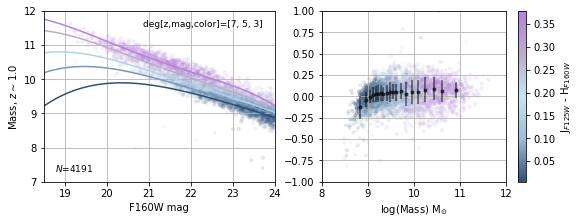

In [138]:
from matplotlib.colors import LinearSegmentedColormap
uphot_bands = ['f_F125W', 'f_F160W']
umag_band = 'f_F160W'
zshow = 1.

degree = [7,5,3]

#clf = linear_model.LinearRegression()

# Use Ridge regressor to constrain high-order parameters and improve
# extrapolation
ridge_alpha = 0.01
clf = linear_model.Ridge(alpha=ridge_alpha)
out = empirical_mass_POSTER(cat, zout, fout, mag_band=umag_band, mag_ZP=25, phot_bands=uphot_bands, degree=degree, clf=clf, zshow=zshow, dq=None, root='3dhst')
#out = empirical_mass2(cat, zout, fout, mag_band='f_F140W', mag_ZP=25, phot_bands=uphot_bands, degree=degree, clf=clf, zshow=zshow, dq=None, root='3dhst')

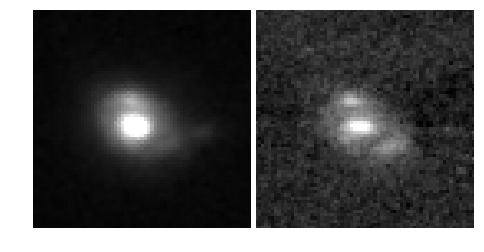

In [29]:
log_stretch = LogStretch(a=1)

def normalize(image,ms = None):
    if ms is None:
        m, M = np.min(image), np.max(image)
        m, M = np.percentile(image,[1,99])
        M *= 4
        m = -0.1*M
        return (image-m) / (M-m), m, M
    else:
        m, M = ms
        return (image-m) / (M-m)

def normalize_stack(image):
        m, M = np.min(image), np.max(image)
        m, M = np.percentile(image,[1,99])
        M *= 4
        m = -0.1*M
        return (image-m) / (M-m)

im = fits.open('../final_data/full_new/j144915+085609_00898.full.fits')
c = im['DSCI'].data
ha = im['Line','Ha'].data

fig = plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(log_stretch(normalize_stack(c)),origin='lower', cmap='gray')
ax1.set_xlim([50,166-50])
ax1.set_ylim([50,166-50])
ax1.set_axis_off()

ax2.imshow(log_stretch(normalize_stack(ha)),origin='lower', cmap='gray')
ax2.set_xlim([50,166-50])
ax2.set_ylim([50,166-50])
ax2.set_axis_off()

fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../figures/poster_galaxy.png',transparent=True,dpi=400)


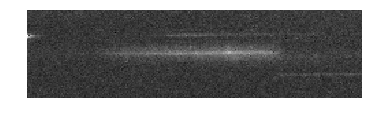

In [283]:
beam = fits.open('../final_data/beams/j144915+085609_00898.beams.fits')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(beam[3].data,origin='lower',cmap='gray')
ax.set_axis_off()
fig.savefig('../figures/poster_galaxy_grism.png',transparent=True,dpi=400)
#plt.show()

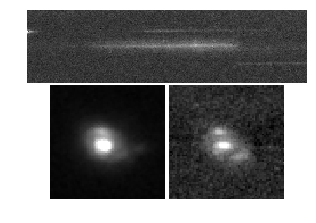

In [279]:
fig = plt.figure(figsize=(5,3.5))
gs = gridspec.GridSpec(5, 4)
ax1 = plt.subplot(gs[0:2,0:4])
ax2 = plt.subplot(gs[2:5,0:2])
ax3 = plt.subplot(gs[2:5,2:4])


ax1.imshow(beam[3].data,origin='lower',cmap='gray')
ax1.set_axis_off()

ax2.imshow(log_stretch(normalize_stack(c)),origin='lower', cmap='gray')
ax2.set_xlim([50,166-50])
ax2.set_ylim([50,166-50])
ax2.set_axis_off()

ax3.imshow(log_stretch(normalize_stack(ha)),origin='lower', cmap='gray')
ax3.set_xlim([50,166-50])
ax3.set_ylim([50,166-50])
ax3.set_axis_off()

fig.subplots_adjust(wspace=-0.4, hspace=0)

In [288]:
t = Table.read('../final_data/clean_sample.fits')

In [295]:
t[t['cat']=='other']
557+301

858

In [296]:
1007-557

450

In [34]:
def profiles(image,zmin,zmax,cat,tab):

    fig = plt.figure(figsize=(6*2,4*2))
    gs = gridspec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[0:2,0:2])
    ax2 = plt.subplot(gs[0:2,2:])
    ax3 = plt.subplot(gs[2, 0:1])
    ax4 = plt.subplot(gs[2, 1:2])
    ax5 = plt.subplot(gs[2, 2:3])
    ax6 = plt.subplot(gs[2, 3:4])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    tokpc = tab['arc_per_pix'][0]*tab['kpcperarc'][0]
    print(tokpc)
    rl = tab['line_rhalf_ellip'][0]*tokpc
    rc = tab['cont_rhalf_ellip'][0]*tokpc
    im = fits.open(image[0])
    cont = im[0].data
    line = im[2].data
    psf = im[4].data
    
    #calculate distance of each pixel in image from center
    yp,xp = np.indices(im[0].data.shape)
    xc = (xp*cont).sum()/cont.sum()
    yc = (yp*cont).sum()/cont.sum()
    R = np.sqrt((xp-xc)**2+(yp-yc)**2)

    #psf centroid
    yp_psf,xp_psf = np.indices(im[4].data.shape)
    xc_psf = (xp_psf*psf).sum()/psf.sum()
    yc_psf = (yp_psf*psf).sum()/psf.sum()
    R_psf = np.sqrt((xp_psf-xc_psf)**2+(yp_psf-yc_psf)**2)

    xmc,ymc,ysc,n = eazy.utils.running_median(R.flatten(),cont.flatten(),bins=range(10))
    xml,yml,ysl,n = eazy.utils.running_median(R.flatten(),line.flatten(),bins=range(10))
    
    norm = ymc[1]/yml[1]
    
    ax1.title.set_text('{0} Radial Profiles: {1:.1f} < z < {2:.1f}'.format(cat[0],zmin,zmax))
    ax1.scatter(R.flatten()*tokpc,cont.flatten(),marker='.',alpha=0.1,color='blue',label='F140W (continuum)')
    ax1.errorbar(xmc*tokpc,ymc,ysc,color='#B97FDF')
    ax1.scatter(R.flatten()*tokpc,line.flatten()*norm,marker='.',color='red',alpha=0.1,label=r'H$\alpha$')
    ax1.errorbar(xml*tokpc,yml*norm,ysl*norm,color='#2D4E76')
    #ax1.scatter(R_psf.flatten()*tokpc,psf.flatten(),marker='.',color='green',alpha=0.1,label='psf')
    ax1.semilogy()
    ax1.set_ylim(1,1000)
    ax1.set_xlim(0,6)
    ax1.legend()
    #ax1.vlines(rc,0.5e-1,10,color='blue',linestyle='dashed',alpha=0.8)
    #ax1.vlines(rl,0.5e-1,10,color='red',linestyle='dashed',alpha=0.8)
    ax1.set_xlabel('r (kpc)')
    
    ms = None
    normed, m_cont, M_cont = normalize(cont,ms)
    vm_cont = log_stretch(normalize(cont,ms=(m_cont,M_cont))).min(),log_stretch(normalize(cont,ms=(m_cont,M_cont))).max()
    ax3.imshow(log_stretch(normalize(cont,ms=(m_cont,M_cont))),origin='lower', cmap='gray',vmin=vm_cont[0],vmax=vm_cont[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax3.set_xlabel('WISP F140W')
    ax3.set_xlim([-15,15])
    ax3.set_ylim([-15,15])
    
    ms = None
    normed, m_line, M_line = normalize(line,ms)
    vm_line = log_stretch(normalize(line,ms=(m_line,M_line))).min(),log_stretch(normalize(line,ms=(m_line,M_line))).max()
    ax4.imshow(log_stretch(normalize(line,ms=(m_line,M_line))),origin='lower', cmap='gray',vmin=vm_line[0],vmax=vm_line[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax4.set_xlabel(r'WISP H$\alpha$')
    ax4.set_xlim([-15,15])
    ax4.set_ylim([-15,15])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    tokpc = tab['arc_per_pix'][1]*tab['kpcperarc'][1]
    print(tokpc)
    rl = tab['line_rhalf_ellip'][1]*tokpc
    rc = tab['cont_rhalf_ellip'][1]*tokpc
    im = fits.open(image[1])
    cont = im[0].data
    line = im[2].data
    psf = im[4].data

    #calculate distance of each pixel in image from center
    yp,xp = np.indices(im[0].data.shape)
    xc = (xp*cont).sum()/cont.sum()
    yc = (yp*cont).sum()/cont.sum()
    R = np.sqrt((xp-xc)**2+(yp-yc)**2)

    #psf centroid
    yp_psf,xp_psf = np.indices(im[4].data.shape)
    xc_psf = (xp_psf*psf).sum()/psf.sum()
    yc_psf = (yp_psf*psf).sum()/psf.sum()
    R_psf = np.sqrt((xp_psf-xc_psf)**2+(yp_psf-yc_psf)**2)

    xmc,ymc,ysc,n = eazy.utils.running_median(R.flatten(),cont.flatten(),bins=range(10))
    xml,yml,ysl,n = eazy.utils.running_median(R.flatten(),line.flatten(),bins=range(10))
    
    norm = ymc[1]/yml[1]
    
    ax2.title.set_text('{0} Radial Profiles: {1:.1f} < z < {2:.1f}'.format(cat[1],zmin,zmax))
    ax2.scatter(R.flatten()*tokpc,cont.flatten(),marker='.',alpha=0.1,color='blue',label='F140W')
    ax2.errorbar(xmc*tokpc,ymc,ysc,color='blue')
    ax2.scatter(R.flatten()*tokpc,line.flatten()*norm,marker='.',color='red',alpha=0.1,label=r'H$\alpha$')
    ax2.errorbar(xml*tokpc,yml*norm,ysl*norm,color='red')
    #ax2.scatter(R_psf.flatten()*tokpc,psf.flatten(),marker='.',color='green',alpha=0.1,label='psf')
    ax2.semilogy()
    ax2.set_ylim(1,1000)
    ax2.set_xlim(0,6)
    ax2.legend()
    #ax2.vlines(rc,0.5e-1,10,color='blue',linestyle='dashed',alpha=0.8)
    #ax2.vlines(rl,0.5e-1,10,color='red',linestyle='dashed',alpha=0.8)
    ax2.set_xlabel('r (kpc)')
    
    ax5.imshow(log_stretch(normalize(cont,ms=(m_cont,M_cont))),origin='lower', cmap='gray',vmin=vm_cont[0],vmax=vm_cont[1],
              extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax5.set_xlim([-15,15])
    ax5.set_ylim([-15,15])
    ax5.set_xlabel('3DHST F140W')
    
    ax6.imshow(log_stretch(normalize(line,ms=(m_line,M_line))),origin='lower', cmap='gray',vmin=vm_line[0],vmax=vm_line[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax6.set_xlabel(r'3DHST H$\alpha$')
    ax6.set_xlim([-15,+15])
    ax6.set_ylim([-15,+15])
    
    gs.tight_layout(fig)
    
    #fig.savefig('../complete_10.5/stack/prof_figs/{0:.1f}_z_{1:.1f}.png'.format(zmin,zmax))
    
def ssfr(image,zmin,zmax,cat,tab):

    fig = plt.figure(figsize=(6*2,4*2))
    gs = gridspec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[0:2,0:2])
    ax2 = plt.subplot(gs[0:2,2:])
    ax3 = plt.subplot(gs[2, 0:1])
    ax4 = plt.subplot(gs[2, 1:2])
    ax5 = plt.subplot(gs[2, 2:3])
    ax6 = plt.subplot(gs[2, 3:4])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    tokpc = tab['arc_per_pix'][0]*tab['kpcperarc'][0]
    print(tokpc)
    rl = tab['line_rhalf_ellip'][0]*tokpc
    rc = tab['cont_rhalf_ellip'][0]*tokpc
    im = fits.open(image[0])
    cont = im[0].data
    line = im[2].data
    psf = im[4].data
    
    #calculate distance of each pixel in image from center
    yp,xp = np.indices(im[0].data.shape)
    xc = (xp*cont).sum()/cont.sum()
    yc = (yp*cont).sum()/cont.sum()
    R = np.sqrt((xp-xc)**2+(yp-yc)**2)

    #psf centroid
    yp_psf,xp_psf = np.indices(im[4].data.shape)
    xc_psf = (xp_psf*psf).sum()/psf.sum()
    yc_psf = (yp_psf*psf).sum()/psf.sum()
    R_psf = np.sqrt((xp_psf-xc_psf)**2+(yp_psf-yc_psf)**2)\
    
    ssfr = line/cont
    ssfr[~np.isfinite(ssfr)] = 0
    
    xm,ym,ys,n = eazy.utils.running_median(R.flatten(),ssfr.flatten(),bins=range(10))

    ax1.title.set_text('{0} Radial Profiles: {1:.1f} < z < {2:.1f}'.format(cat[0],zmin,zmax))
    ax1.scatter(R.flatten()*tokpc,ssfr.flatten(),marker='.',alpha=0.1,color='blue',label='F140W')
    ax1.errorbar(xm*tokpc,ym,ys,color='blue')
    #ax1.scatter(R.flatten()*tokpc,line.flatten()/cont.flatten(),marker='.',color='red',alpha=0.1,label=r'H$\alpha$')
    #ax1.errorbar(xml*tokpc,yml*norm,ysl*norm,color='red')
    #ax1.scatter(R_psf.flatten()*tokpc,psf.flatten(),marker='.',color='green',alpha=0.1,label='psf')
    ax1.semilogy()
    ax1.set_ylim([10**-4,1])
    ax1.set_xlim([0,10])
    ax1.legend()
    #ax1.vlines(rc,0.5e-1,10,color='blue',linestyle='dashed',alpha=0.8)
    #ax1.vlines(rl,0.5e-1,10,color='red',linestyle='dashed',alpha=0.8)
    ax1.set_xlabel('r (kpc)')
    
    
    ms = None
    normed, m_cont, M_cont = normalize(cont,ms)
    vm_cont = log_stretch(normalize(cont,ms=(m_cont,M_cont))).min(),log_stretch(normalize(cont,ms=(m_cont,M_cont))).max()
    ax3.imshow(log_stretch(normalize(cont,ms=(m_cont,M_cont))),origin='lower', cmap='gray',vmin=vm_cont[0],vmax=vm_cont[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax3.set_xlabel('WISP F140W')
    ax3.set_xlim([-15,15])
    ax3.set_ylim([-15,15])
    
    ms = None
    normed, m_line, M_line = normalize(line,ms)
    vm_line = log_stretch(normalize(line,ms=(m_line,M_line))).min(),log_stretch(normalize(line,ms=(m_line,M_line))).max()
    ax4.imshow(log_stretch(normalize(line,ms=(m_line,M_line))),origin='lower', cmap='gray',vmin=vm_line[0],vmax=vm_line[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax4.set_xlabel(r'WISP H$\alpha$')
    ax4.set_xlim([-15,15])
    ax4.set_ylim([-15,15])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    tokpc = tab['arc_per_pix'][1]*tab['kpcperarc'][1]
    print(tokpc)
    rl = tab['line_rhalf_ellip'][1]*tokpc
    rc = tab['cont_rhalf_ellip'][1]*tokpc
    im = fits.open(image[1])
    cont = im[0].data
    line = im[2].data
    psf = im[4].data

    #calculate distance of each pixel in image from center
    yp,xp = np.indices(im[0].data.shape)
    xc = (xp*cont).sum()/cont.sum()
    yc = (yp*cont).sum()/cont.sum()
    R = np.sqrt((xp-xc)**2+(yp-yc)**2)

    #psf centroid
    yp_psf,xp_psf = np.indices(im[4].data.shape)
    xc_psf = (xp_psf*psf).sum()/psf.sum()
    yc_psf = (yp_psf*psf).sum()/psf.sum()
    R_psf = np.sqrt((xp_psf-xc_psf)**2+(yp_psf-yc_psf)**2)

    xmc,ymc,ysc,n = eazy.utils.running_median(R.flatten(),cont.flatten(),bins=range(10))
    xml,yml,ysl,n = eazy.utils.running_median(R.flatten(),line.flatten(),bins=range(10))
    
    norm = ymc[1]/yml[1]
    ssfr = line/cont
    ssfr[~np.isfinite(ssfr)] = 0
    print(np.max(ssfr.flatten()))
    
    ax2.title.set_text('{0} Radial Profiles: {1:.1f} < z < {2:.1f}'.format(cat[0],zmin,zmax))
    ax2.scatter(R.flatten()*tokpc,ssfr.flatten(),marker='.',alpha=0.1,color='blue',label='F140W')
    #ax1.errorbar(xmc*tokpc,ymc,ysc,color='blue')
    #ax1.scatter(R.flatten()*tokpc,line.flatten()/cont.flatten(),marker='.',color='red',alpha=0.1,label=r'H$\alpha$')
    #ax1.errorbar(xml*tokpc,yml*norm,ysl*norm,color='red')
    #ax1.scatter(R_psf.flatten()*tokpc,psf.flatten(),marker='.',color='green',alpha=0.1,label='psf')
    ax2.semilogy()
    ax2.set_ylim([10**-4,1])
    ax2.set_xlim([0,10])
    ax2.legend()
    #ax1.vlines(rc,0.5e-1,10,color='blue',linestyle='dashed',alpha=0.8)
    #ax1.vlines(rl,0.5e-1,10,color='red',linestyle='dashed',alpha=0.8)
    ax2.set_xlabel('r (kpc)')
    
    ax5.imshow(log_stretch(normalize(cont,ms=(m_cont,M_cont))),origin='lower', cmap='gray',vmin=vm_cont[0],vmax=vm_cont[1],
              extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax5.set_xlim([-15,15])
    ax5.set_ylim([-15,15])
    ax5.set_xlabel('3DHST F140W')
    
    ax6.imshow(log_stretch(normalize(line,ms=(m_line,M_line))),origin='lower', cmap='gray',vmin=vm_line[0],vmax=vm_line[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax6.set_xlabel(r'3DHST H$\alpha$')
    ax6.set_xlim([-15,+15])
    ax6.set_ylim([-15,+15])
    
    gs.tight_layout(fig)
    
    #fig.savefig('../complete_10.5/stack/prof_figs/{0:.1f}_z_{1:.1f}.png'.format(zmin,zmax))

0.5111444334474237
0.5111444334474237
16772393.37739445


/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in true_divide
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:224: RuntimeWarning: divide by zero encountered in true_divide


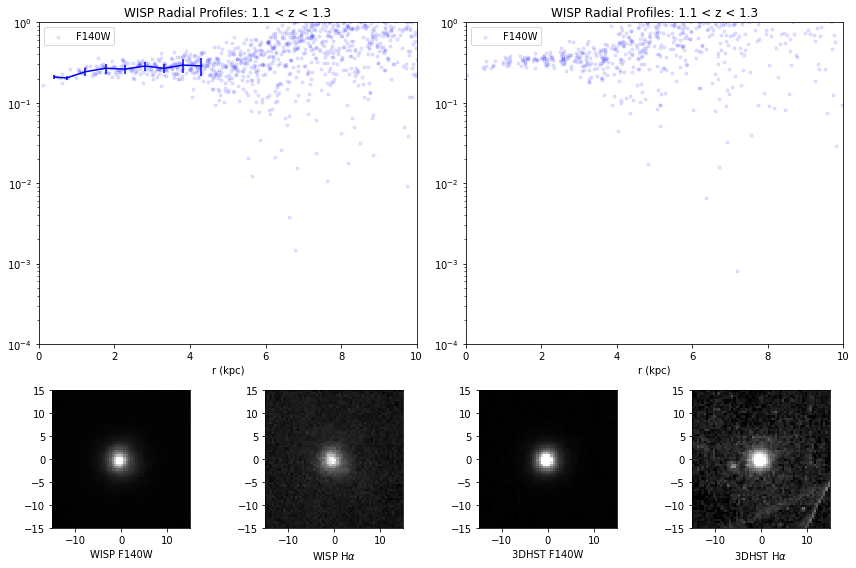

In [36]:
#profiles(image,zmin,zmax,cat,tab)
tab = Table.read('../final_data/stack_stats.fits')
tab['arc_per_pix'] = np.ones(len(tab))*0.06
ssfr(['../final_data/stack/fits_noseg/stack_!wisp_z1.1-z1.5_n57.fits',
          '../final_data/stack/fits_noseg/stack_wisp_z1.1-z1.3_n116.fits'],1.1,1.3,
         ['WISP','3DHST'],tab[tab['zmax']==1.3])

#     profiles(['../final_data/stack/fits_noseg/stack_wisp_z{0}-z{1}_n{2}.fits'.format(tab['zmin'],).sum()),
#               '../final_data/stack/fits_noseg/stack_!wisp_z{0}-z{1}_n{2}.fits'.format(0.7+.2*i,0.9+.2*i,((samp_stack['cat']!='wisp') & z).sum())],
#              zmin,zmax,
#              ['WISP','3DHST'],
#              output_table[output_table['zmax']==zmax])




0.5111444334474237
0.5111444334474237


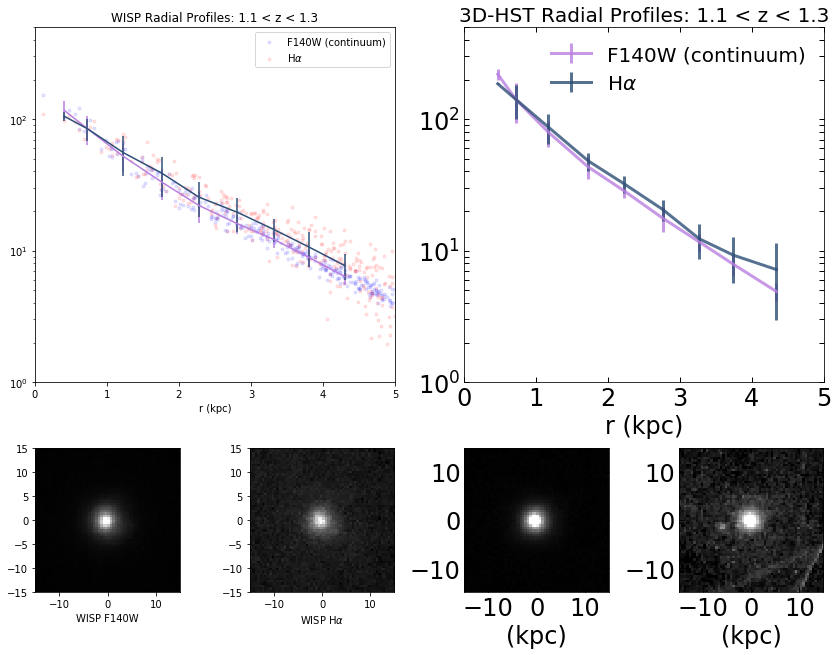

In [119]:
def profiles(image,zmin,zmax,cat,tab):

    fig = plt.figure(figsize=(6*2,4*2.3))
    gs = gridspec.GridSpec(3, 4)
    ax1 = plt.subplot(gs[0:2,0:2])
    ax2 = plt.subplot(gs[0:2,2:])
    ax3 = plt.subplot(gs[2, 0:1])
    ax4 = plt.subplot(gs[2, 1:2])
    ax5 = plt.subplot(gs[2, 2:3])
    ax6 = plt.subplot(gs[2, 3:4])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    tokpc = tab['arc_per_pix'][0]*tab['kpcperarc'][0]
    print(tokpc)
    rl = tab['line_rhalf_ellip'][0]*tokpc
    rc = tab['cont_rhalf_ellip'][0]*tokpc
    im = fits.open(image[0])
    cont = im[0].data
    line = im[2].data
    psf = im[4].data
    
    #calculate distance of each pixel in image from center
    yp,xp = np.indices(im[0].data.shape)
    xc = (xp*cont).sum()/cont.sum()
    yc = (yp*cont).sum()/cont.sum()
    R = np.sqrt((xp-xc)**2+(yp-yc)**2)

    #psf centroid
    yp_psf,xp_psf = np.indices(im[4].data.shape)
    xc_psf = (xp_psf*psf).sum()/psf.sum()
    yc_psf = (yp_psf*psf).sum()/psf.sum()
    R_psf = np.sqrt((xp_psf-xc_psf)**2+(yp_psf-yc_psf)**2)

    xmc,ymc,ysc,n = eazy.utils.running_median(R.flatten(),cont.flatten(),bins=range(10))
    xml,yml,ysl,n = eazy.utils.running_median(R.flatten(),line.flatten(),bins=range(10))
    
    norm = ymc[1]/yml[1]
    
    ax1.title.set_text('{0} Radial Profiles: {1:.1f} < z < {2:.1f}'.format(cat[0],zmin,zmax))
    ax1.scatter(R.flatten()*tokpc,cont.flatten(),marker='.',alpha=0.1,color='blue',label='F140W (continuum)')
    ax1.errorbar(xmc*tokpc,ymc,ysc,color='#B97FDF')
    ax1.scatter(R.flatten()*tokpc,line.flatten()*norm,marker='.',color='red',alpha=0.1,label=r'H$\alpha$')
    ax1.errorbar(xml*tokpc,yml*norm,ysl*norm,color='#2D4E76')
    #ax1.scatter(R_psf.flatten()*tokpc,psf.flatten(),marker='.',color='green',alpha=0.1,label='psf')
    ax1.semilogy()
    ax1.set_ylim(1,500)
    ax1.set_xlim(0,5)
    ax1.legend()
    #ax1.vlines(rc,0.5e-1,10,color='blue',linestyle='dashed',alpha=0.8)
    #ax1.vlines(rl,0.5e-1,10,color='red',linestyle='dashed',alpha=0.8)
    ax1.set_xlabel('r (kpc)')
    
    ms = None
    normed, m_cont, M_cont = normalize(cont,ms)
    vm_cont = log_stretch(normalize(cont,ms=(m_cont,M_cont))).min(),log_stretch(normalize(cont,ms=(m_cont,M_cont))).max()
    ax3.imshow(log_stretch(normalize(cont,ms=(m_cont,M_cont))),origin='lower', cmap='gray',vmin=vm_cont[0],vmax=vm_cont[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax3.set_xlabel('WISP F140W')
    ax3.set_xlim([-15,15])
    ax3.set_ylim([-15,15])
    
    ms = None
    normed, m_line, M_line = normalize(line,ms)
    vm_line = log_stretch(normalize(line,ms=(m_line,M_line))).min(),log_stretch(normalize(line,ms=(m_line,M_line))).max()
    ax4.imshow(log_stretch(normalize(line,ms=(m_line,M_line))),origin='lower', cmap='gray',vmin=vm_line[0],vmax=vm_line[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    ax4.set_xlabel(r'WISP H$\alpha$')
    ax4.set_xlim([-15,15])
    ax4.set_ylim([-15,15])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    tokpc = tab['arc_per_pix'][1]*tab['kpcperarc'][1]
    print(tokpc)
    rl = tab['line_rhalf_ellip'][1]*tokpc
    rc = tab['cont_rhalf_ellip'][1]*tokpc
    im = fits.open(image[1])
    cont = im[0].data
    line = im[2].data
    psf = im[4].data

    #calculate distance of each pixel in image from center
    yp,xp = np.indices(im[0].data.shape)
    xc = (xp*cont).sum()/cont.sum()
    yc = (yp*cont).sum()/cont.sum()
    R = np.sqrt((xp-xc)**2+(yp-yc)**2)

    #psf centroid
    yp_psf,xp_psf = np.indices(im[4].data.shape)
    xc_psf = (xp_psf*psf).sum()/psf.sum()
    yc_psf = (yp_psf*psf).sum()/psf.sum()
    R_psf = np.sqrt((xp_psf-xc_psf)**2+(yp_psf-yc_psf)**2)

    xmc,ymc,ysc,n = eazy.utils.running_median(R.flatten(),cont.flatten(),bins=range(10))
    xml,yml,ysl,n = eazy.utils.running_median(R.flatten(),line.flatten(),bins=range(10))
    
    norm = ymc[1]/yml[1]
    
    ax2.set_title('3D-HST Radial Profiles: {0:.1f} < z < {1:.1f}'.format(zmin,zmax),fontsize = 20)
    #ax2.scatter(R.flatten()*tokpc,cont.flatten(),marker='.',alpha=0.2, color='#B97FDF',linewidth=0,s=80)
    ax2.errorbar(xmc*tokpc,ymc,ysc,color='#B97FDF',label='F140W (continuum)',linewidth=3,alpha=0.8)
    #ax2.scatter(R.flatten()*tokpc,line.flatten()*norm,marker='.',color='#2D4E76',alpha=0.2,linewidth=0,s=80)
    ax2.errorbar(xml*tokpc,yml*norm,ysl*norm,color='#2D4E76',label=r'H$\alpha$',linewidth=3,alpha=0.8)
    #ax2.scatter(R_psf.flatten()*tokpc,psf.flatten(),marker='.',color='green',alpha=0.1,label='psf')
    ax2.semilogy()
    ax2.set_ylim(1,500)
    ax2.set_xlim(0,5)
    

    leg = ax2.legend(fontsize=20,loc='upper right',fancybox=True)
    leg.get_frame().set_alpha(0)

    #ax2.vlines(rc,0.5e-1,10,color='blue',linestyle='dashed',alpha=0.8)
    #ax2.vlines(rl,0.5e-1,10,color='red',linestyle='dashed',alpha=0.8)
    ax2.set_xlabel('r (kpc)',fontsize = 24)
    ax2.tick_params(which='both',labelsize=24,direction='in',length=5,width=1,top=True,right=True)

    
    ax5.imshow(log_stretch(normalize(cont,ms=(m_cont,M_cont))),origin='lower', cmap='gray',vmin=vm_cont[0],vmax=vm_cont[1],
              extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    #ax5.set_title('F140W',fontsize = 24)
    ax5.set_xlim([-15,15])
    ax5.set_ylim([-15,15])
    ax5.set_xlabel('(kpc)',fontsize = 24)
    ax5.tick_params(which='both',labelsize=24,direction='in',length=5,width=1,top=True,right=True)

    ax6.imshow(log_stretch(normalize(line,ms=(m_line,M_line))),origin='lower', cmap='gray',vmin=vm_line[0],vmax=vm_line[1],
               extent=[-xc*tokpc,xc*tokpc,-xc*tokpc,xc*tokpc])
    #ax6.set_title(r'H$\alpha$',fontsize = 24)
    ax6.set_xlabel('(kpc)',fontsize = 24)
    ax6.set_xlim([-15,+15])
    ax6.set_ylim([-15,+15])
    ax6.tick_params(which='both',labelsize=24,direction='in',length=5,width=1,top=True,right=True)

    gs.tight_layout(fig)
    
    fig.savefig('profiles.png',dpi=400,transparent=True)
tab = Table.read('../final_data/stack_stats.fits')
tab['arc_per_pix'] = np.ones(len(tab))*0.06
profiles(['../final_data/stack/fits_noseg/stack_!wisp_z1.1-z1.5_n57.fits',
          '../final_data/stack/fits_noseg/stack_wisp_z1.1-z1.3_n116.fits'],1.1,1.3,
         ['WISP','3DHST'],tab[tab['zmax']==1.3])

In [121]:
im = fits.open('../final_data/stack/fits_noseg/stack_wisp_z0.9-z1.1_n71.fits')

/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/alizabeverage/anaconda3/envs/grizli-dev/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5,0,'r (kpc)')

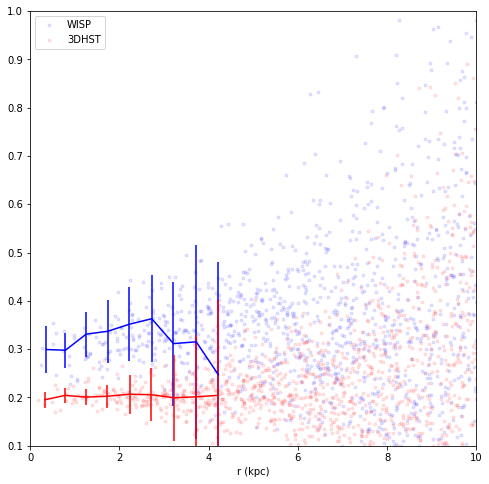

In [163]:
im_w = fits.open('../final_data/stack/fits_aas/stack_wisp_z0.9-z1.1_n96.fits')
im_3 = fits.open('../final_data/stack/fits_noseg/stack_!wisp_z0.9-z1.1_n69.fits')

tokpc = tab['arc_per_pix'][2]*tab['kpcperarc'][2]

contw = im_w[0].data
cont3 = im_3[0].data
linew = im_w[2].data
line3 = im_3[2].data


#calculate distance of each pixel in image from center
ypw,xpw = np.indices(contw.shape)
xcw = (xpw*contw).sum()/contw.sum()
ycw = (ypw*contw).sum()/contw.sum()
Rw = np.sqrt((xpw-xcw)**2+(ypw-ycw)**2)

yp3,xp3 = np.indices(cont3.shape)
xc3 = (xp3*cont3).sum()/cont3.sum()
yc3 = (yp3*cont3).sum()/cont3.sum()
R3 = np.sqrt((xp3-xc3)**2+(yp3-yc3)**2)

ssfr3 = line3/cont3
ssfr3[~np.isfinite(ssfr3)] = 0

ssfrw = linew/contw
ssfrw[~np.isfinite(ssfrw)] = 0

xm3,ym3,ys3,n3 = eazy.utils.running_median(R3.flatten()*tokpc,ssfr3.flatten(),bins=range(10))
xmw,ymw,ysw,nw = eazy.utils.running_median(Rw.flatten()*tokpc,ssfrw.flatten(),bins=range(10))


fig = plt.figure(figsize=[8,8])
ax1 = fig.add_subplot(111)

#ax1.title.set_text('{0} Radial Profiles: {1:.1f} < z < {2:.1f}'.format(cat[0],zmin,zmax))
ax1.scatter(Rw.flatten()*tokpc,ssfrw.flatten(),marker='.',alpha=0.1,color='blue',label='WISP')
ax1.scatter(R3.flatten()*tokpc,ssfr3.flatten(),marker='.',alpha=0.1,color='red',label='3DHST')
ax1.errorbar(xmw*tokpc,ymw,ysw,color='blue')
ax1.errorbar(xm3*tokpc,ym3,ys3,color='red')
#ax1.semilogy()
ax1.set_ylim([10**-1,1])
ax1.set_xlim([0,10])
ax1.legend()
ax1.set_xlabel('r (kpc)')



In [156]:
tab = Table.read('../final_data/stack_stats.fits')
tab['arc_per_pix'] = np.ones(len(tab))*0.06

In [75]:
im = fits.open('../final_data/stack/fits_noseg/stack_!wisp_z1.1-z1.5_n57.fits')
im[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   80                                                  
NAXIS2  =                   80                                                  
EXTEND  =                    T                                                  